# A TUTORIAL ON GAUSSIAN MIXTURE MODELS

by Sebastian T. Glavind, May, 2020

In [2]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In this tutorial, we will consider how to use Gaussian mixture models to find latent clusters in a data set. In this regard, we will employ the expectation maximization (EM) algorithm to learn a cluster representation for a fixed number of clusters, and we will consider how to pick the optimal number of clusters, see e.g. Theodoridis (2020; Sec. 12.6) for a reference on Gaussian mixture models and learning using the EM algorithm.

***
S. Theodoridis. Machine learning: a Bayesian and optimization perspective. Academic Press, 2020.
***

## Sample data

### True model parameters

In [3]:
# Define parameters for 3 clusters
mu_mix = np.array([ [10,3],[1,1], [5,4] ]) # mean
Sig_mix = np.array([ [[1,0],[0,1]],[[1.5,0],[0,1.5]],[[2,0],[0,2]] ]) # covariance

### Generate data

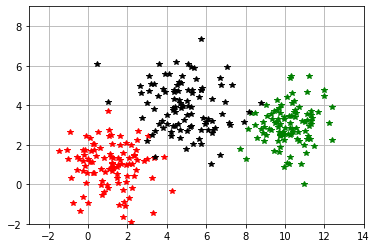

In [4]:
nX_i = 100 # data points pr. cluster
X3d = np.zeros((3,nX_i,2))
np.random.seed(10)
for i in range(3): 
    X3d[i,:,:] = np.random.multivariate_normal(mu_mix[i,:], Sig_mix[i], nX_i)
    
X = X3d.reshape(3*nX_i,2)
nX, mX = X.shape

plt.plot(X3d[0,:,0], X3d[0,:,1],'*g');
plt.plot(X3d[1,:,0], X3d[1,:,1],'*r');
plt.plot(X3d[2,:,0], X3d[2,:,1],'*k');
plt.xlim([-3,14])
plt.ylim([-2,9])
plt.grid();

## The EM algorithm

Based on Theodoridis (2020), Sec. 12.6.

***
S. Theodoridis. Machine learning: a Bayesian and optimization perspective. Academic Press, 2020.
***

### Initialize algorithm

In [5]:
n_clust = 3 # no of cluster to fit

# Initial parameters (typically the k-means algorithm is used, but we can also do e.g. ...)
batch_sizes = np.zeros(3)
while np.min(batch_sizes) < 10:
    batch_sizes = (nX * np.random.dirichlet([10,10,10])).astype(int)
    batch_sizes[-1] = nX - np.sum(batch_sizes[0:n_clust-1])
indices = np.random.permutation(nX) 
mu_mix0 = np.zeros([n_clust, mX])
Sig_mix0 = np.zeros([n_clust, mX, mX])
X_perm = X[indices,:]
batch_counter = 0
for j in range(n_clust):
    X_perm_j = X_perm[batch_counter:batch_counter + batch_sizes[j],:]
    mu_mix0[j,:] = np.mean(X_perm_j, axis=0)
    Sig_mix0[j,:,:] = np.cov(X_perm_j.T)
    batch_counter += batch_sizes[j]
Pk0 = np.ones(n_clust)/n_clust

In [6]:
eps = 1e-8 # Prevent numerical overflow; make sure we do not devide by zero
sumPP0 = -np.inf # access convergence of likelihood
n_it_max = 1000 # miximum no. of iterations

### EM iterator

In [7]:
for i in range(n_it_max):
    
    if i > 0:
        mu_mix0 = mu_mix1
        Sig_mix0 = Sig_mix1
        Pk0 = Pk1
        sumPP0 = sumPP1
        
    # E-step:
    PP = np.zeros((nX,3))
    for j in range(n_clust):
        PP[:,j] = ss.multivariate_normal(mu_mix0[j,:], Sig_mix0[j,:,:]).logpdf(X) + np.log(Pk0[j]) # unnormalized PP (log space)
    normPP = np.log(np.sum(np.exp(PP),axis=1)) # normalizer for PP (log space)
    gamma = np.exp(PP - normPP[:,None]) # gamma (probability space)

    # M-step:
    mu_mix1 = np.zeros(mu_mix0.shape)
    Sig_mix1 = np.zeros(Sig_mix0.shape)
    Pk1 = np.zeros(n_clust)
    for j in range(n_clust):
        sumGamma_j = np.sum(gamma[:,j]) + eps
        mu_mix1[j,:] = gamma[:,j].dot(X) / sumGamma_j
        Sig_mix1[j,:,:] = np.dot( (gamma[:,j][:,None]*(X - mu_mix1[j,:])).T, (X - mu_mix1[j,:]) ) / sumGamma_j
        Pk1[j] = sumGamma_j / nX
        
    # access convergence
    sumPP1 = np.sum(PP) 
    
    if abs( sumPP1 - sumPP0 ) < 1e-4 * abs( sumPP0 ):
        break
        
print('Results:')
mu_mix1, Sig_mix1, Pk1, i

Results:


(array([[ 1.13091005,  0.96346553],
        [10.14074866,  3.00717265],
        [ 4.87124732,  3.90298519]]),
 array([[[ 1.38241814, -0.0970567 ],
         [-0.0970567 ,  1.23679043]],
 
        [[ 0.97018196,  0.09381933],
         [ 0.09381933,  0.9468303 ]],
 
        [[ 1.77310418, -0.25326814],
         [-0.25326814,  1.57921498]]]),
 array([0.33475821, 0.33804009, 0.3272017 ]),
 51)

### Plot resulting model

In [8]:
# Load functionalities
from matplotlib.patches import Ellipse

# Plotting function
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

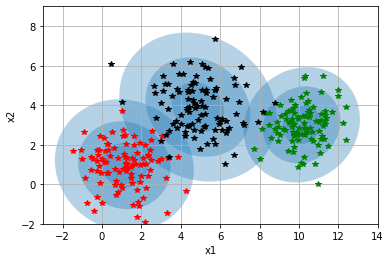

In [9]:
# Plotting
plt.plot(X3d[0,:,0], X3d[0,:,1],'*g');
plt.plot(X3d[1,:,0], X3d[1,:,1],'*r');
plt.plot(X3d[2,:,0], X3d[2,:,1],'*k');
plt.xlim([-3,14])
plt.ylim([-2,9])
plt.xlabel('x1')
plt.ylabel('x2')
for j in range(n_clust): 
    draw_ellipse(mu_mix1[j,:], Sig_mix1[j,:,:], alpha=Pk1[j])
plt.grid();

### Test against scikit-learn implementation

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [10]:
# load scikit
from sklearn.mixture import GaussianMixture

# Fit scikit model
gmm = GaussianMixture(n_components=3, n_init=10)
gmm.fit(X);

In [11]:
print('Results:')
mus_skl = gmm.means_
covs_skl = gmm.covariances_
ws_skl = gmm.weights_
mus_skl, covs_skl, ws_skl

Results:


(array([[10.13424602,  3.0065624 ],
        [ 4.86817373,  3.90873688],
        [ 1.13343205,  0.96866956]]),
 array([[[ 0.98204385,  0.09512082],
         [ 0.09512082,  0.94642996]],
 
        [[ 1.72779113, -0.24802591],
         [-0.24802591,  1.57694201]],
 
        [[ 1.38433011, -0.09356273],
         [-0.09356273,  1.24748712]]]),
 array([0.33908517, 0.32531483, 0.3356    ]))

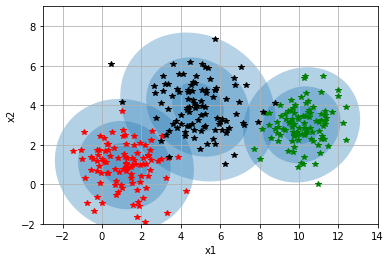

In [12]:
plt.plot(X3d[0,:,0], X3d[0,:,1],'*g');
plt.plot(X3d[1,:,0], X3d[1,:,1],'*r');
plt.plot(X3d[2,:,0], X3d[2,:,1],'*k');
plt.xlim([-3,14])
plt.ylim([-2,9])
plt.xlabel('x1')
plt.ylabel('x2')
for j in range(n_clust): 
    draw_ellipse(mus_skl[j,:], covs_skl[j,:,:], alpha=ws_skl[j])
plt.grid();

### Model selection

#### Model selection using the evidence lower bound

i.e. optimal number of components using the evidence lower bound (ELBO)

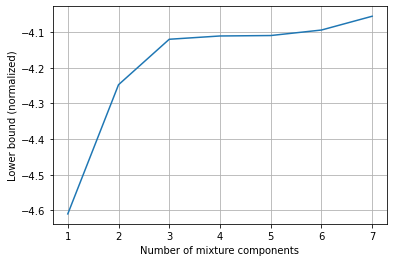

In [13]:
Cs = range(1, 8)
lbs = []

for C in Cs:
    gmm = GaussianMixture(n_components=C, n_init=10)
    gmm.fit(X)
    lbs.append(gmm.lower_bound_)
    
plt.plot(Cs, lbs)
plt.xlabel('Number of mixture components')
plt.ylabel('Lower bound (normalized)')
plt.grid();

Note that the curve flattens at 3 components.

#### Model selection using the information criteria

i.e. optimal number of components using the Bayesian information criterion (BIC) or the integrated complete-data likelihood (ICL), see Schwarz et al.(1978) or Biernacki et al.(2000), respectively.

***
G. Schwarz et al., “Estimating the dimension of a model,” The annals of statistics,
vol. 6, no. 2, pp. 461–464, 1978.

C. Biernacki, G. Celeux, and G. Govaert, “Assessing a mixture model for clustering with the integrated completed likelihood,” IEEE transactions on pattern analysis and machine intelligence, vol. 22, no. 7, pp. 719–725, 2000.
***

In [23]:
# Test sklearn BIC implementation and calculate corresponding ICL

print('BIC comparison:')
print(gmm.bic(X)) # sklearn
loglik = np.sum(gmm.score_samples(X)); #print(loglik)
nu = (len(gmm.weights_))*( mX + mX*(mX+1)/2 + 1 ) -1; #print(nu)
bic = 2*loglik - nu*np.log(nX); print(bic)

print('ICL:')
ent_term_zhat = 2*np.sum(np.log(np.max(gmm.predict_proba(X), axis=1))); # print(ent_term_zhat) # (hard) entropy term
icl = bic + ent_term_zhat; print(icl)

BIC comparison:
2670.730848796643
-2670.730848796643
ICL:
-2794.6255329901737


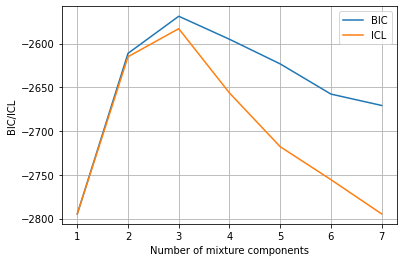

In [15]:
Cs = range(1, 8)
bics = []
icls = []

for C in Cs:
    gmm = GaussianMixture(n_components=C, n_init=10)
    gmm.fit(X)
    bic = gmm.bic(X)*(-1)
    icl = bic + 2*np.sum(np.log(np.max(gmm.predict_proba(X), axis=1)))
    
    bics.append(bic)
    icls.append(icl)

plt.plot(Cs, bics)
plt.plot(Cs, icls)
plt.legend(('BIC', 'ICL'))
plt.xlabel('Number of mixture components')
plt.ylabel('BIC/ICL')
plt.grid();

Note that both curves peaks at 3 components.

Note also that we only consider GMM representations with a full covariance matrix in this tutorial, i.e. default in sklearn (covariance_type{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}), but we could also consider other covariance formulations as well. In case different covariance formulations are considered, the fitting procedure above would simply be augmented with an outer loop over the covariance type, and we would again pick the model reflecting the maximum BIC or ICL value.